In [18]:
import pandas as pd
from pyarrow import csv
import pyarrow.parquet as pq

# load the parquet file
df = pq.read_table('data/traffic_data.parquet').to_pandas()

# load latlon data
latlon = pd.read_csv('data/latlon.csv')

pop = pd.read_csv('data/population.csv')
# change types to int
pop['year'] = pop['year'].astype(int)
pop['population'] = pop['population'].astype(int)
pop = pop[::-1]
# reverse just the index
pop = pop.reset_index(drop=True)
pop['growth_rate'] = 1
for i in range(len(pop)):
    if i > 0:
        pop['growth_rate'][i] = pop['population'][i] / pop['population'][i-1]

# function that takes in a tuple and returns a list
def tuple_to_list(tup):
    return [tup[0], tup[1]]

# function that takes in a tuple stored as string and returns a tuple
def string_to_tuple(tup_str):
    # remove the parentheses and split by comma
    tup_str = tup_str[1:-1]
    return tuple(map(float, tup_str.split(',')))

latlon["latlon"] = latlon["latlon"].apply(lambda x: string_to_tuple(x))
latlon["latlon"] = latlon["latlon"].apply(lambda x: tuple_to_list(x))

df = df.reset_index()

C:\Users\bence\AppData\Local\Temp\ipykernel_6660\1590911301.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop['growth_rate'][i] = pop['population'][i] / pop['population'][i-1]


In [19]:
# take only date column and columns with T in name
stationAvailability = df[["datetime"] + [col for col in df.columns if " T" in col]]

for station in stationAvailability.columns[1:]:
    # convert to true or false based on value being -1 or else
    stationAvailability.loc[:,station] = stationAvailability.loc[:,station].apply(lambda x: 0 if x == -1 else 1)

stationAvailabilityCopy = stationAvailability.copy()

for station in stationAvailability.columns[1:]:
    stationAvailability.loc[:,station] = stationAvailability.loc[:,station]-stationAvailability.loc[:,station].shift(1)
    stationAvailability.loc[0,station] = 0 if df.loc[0,station] == -1 else 1

# discard all rows where all values are 0
stationAvailability = stationAvailability[abs(stationAvailability.iloc[:, 1:]).sum(axis=1) > 0]

<Figure size 1400x1000 with 0 Axes>

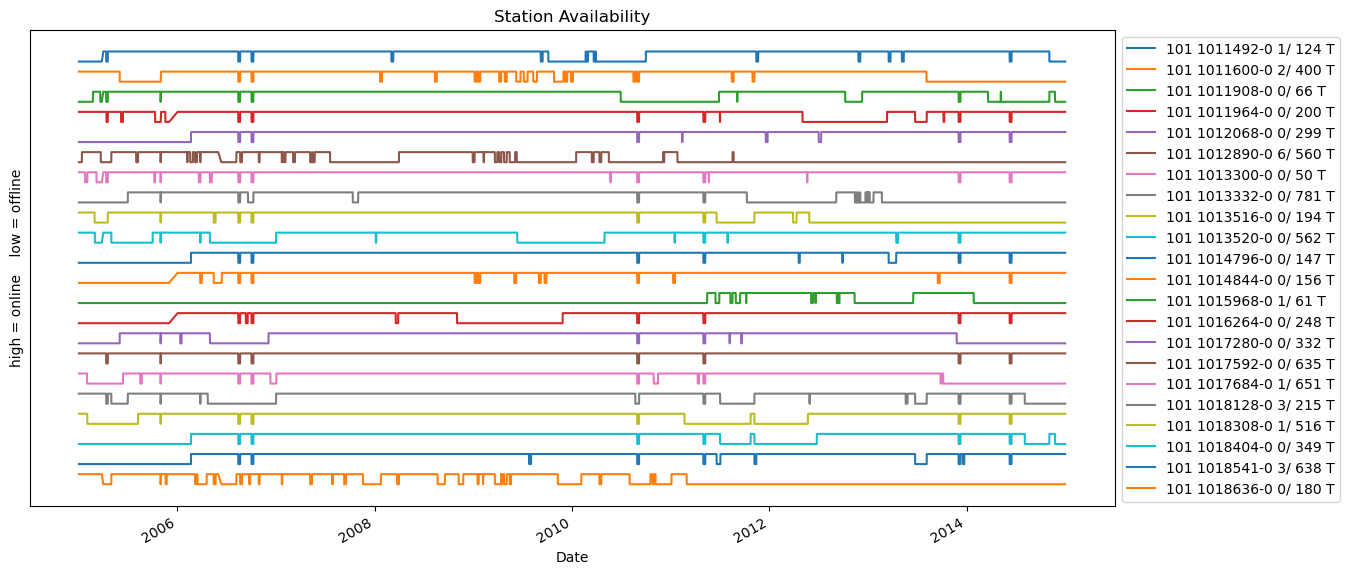

In [20]:
# plot the data
import matplotlib.pyplot as plt

""" 
data = stationAvailability.copy()
i = 0
for col in data.columns[1:]:
    # convert to true or false based on value being -1 or else
    data[col] = data[col] + i
    i -= 4
# scatter plot the data
plt.figure(figsize=(14, 10))
#for station in data.columns[1:]:
#    plt.scatter(data["datetime"], data[station], s=3, alpha=0.5, label=station)
data.plot(x="datetime", figsize=(14, 10), title="Station Availability")
plt.xlabel("Date")
plt.ylabel("Station Availability")
# flip display order of legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
"""

data = stationAvailabilityCopy.copy()
i = 0
for col in data.columns[1:]:
    # convert to true or false based on value being -1 or else
    data[col] = data[col] + i
    i -= 2
# scatter plot the data
plt.figure(figsize=(14, 10))
#for station in data.columns[1:]:
#    plt.scatter(data["datetime"], data[station], s=3, alpha=0.5, label=station)
data.plot(x="datetime", figsize=(14, 7), title="Station Availability")
plt.xlabel("Date")
plt.ylabel("high = online    low = offline")
# hide y ticks
plt.yticks([])
# flip display order of legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))



In [21]:
#print(stationAvailability[stationAvailability.iloc[:,1]!=0.0].iloc[:,0].tolist())

def pairer(l):
    return [(l[i], l[i + 1]) for i in range(0, len(l), 2)]

#pairer(stationAvailability[stationAvailability.iloc[:,1]!=0.0].iloc[:,0].tolist())
#stationAvailability.columns[1]

print(stationAvailability[stationAvailability.iloc[:,1]== 1.0].iloc[:,0].tolist())
print(stationAvailability[stationAvailability.iloc[:,1]==-1.0].iloc[:,0].tolist())
#print(stationAvailability[stationAvailability.iloc[:,1]== 1.0].iloc[:,0].tolist()[0] == pd.Timestamp("2005-01-01 00:00:00"))
#print(stationAvailability[stationAvailability.iloc[:,1]== 1.0].iloc[:,0].tolist()[0] == pd.Timestamp("2005-01-01 00:00:00"))
print(pd.Timestamp("2019-01-01 01:00:00") > pd.Timestamp("2019-01-01 00:00:00"))

def onoffpairs(on,off):
    startsAsOn = on[0] == pd.Timestamp("2005-01-01 00:00:00")
    endsAsOn = on[-1] > off[-1]

    if not(startsAsOn):
        off = [pd.Timestamp("2005-01-01 00:00:00")] + off
    if endsAsOn:
        off = off + [pd.Timestamp("2014-12-31 00:00:00")]
    else:
        on = on + [pd.Timestamp("2014-12-31 00:00:00")]
    
    online = []
    offline = []

    #print(startsAsOn, endsAsOn)

    if startsAsOn and endsAsOn:
        for i in range(len(on)-1):
            online  += [[on[i], off[i]]]
            offline += [[off[i], on[i+1]]]
        online += [[on[-1], off[-1]]]

    elif not(startsAsOn) and not(endsAsOn):
        for i in range(len(off)-1):
            offline += [[off[i], on[i]]]
            online  += [[on[i], off[i+1]]]
        offline += [[off[-1], on[-1]]]

    elif startsAsOn and not(endsAsOn):
        for i in range(len(on)-1):
            online  += [[on[i], off[i]]]
            offline += [[off[i], on[i+1]]]
    
    elif not(startsAsOn) and endsAsOn:
        for i in range(len(off)-1):
            offline += [[off[i], on[i]]]
            online  += [[on[i], off[i+1]]]
    
    return online, offline


[Timestamp('2005-04-01 00:00:00'), Timestamp('2005-04-18 00:00:00'), Timestamp('2006-08-21 00:00:00'), Timestamp('2006-10-09 00:00:00'), Timestamp('2008-03-10 00:00:00'), Timestamp('2009-09-14 00:00:00'), Timestamp('2010-02-20 00:00:00'), Timestamp('2010-03-01 00:00:00'), Timestamp('2010-03-28 00:00:00'), Timestamp('2010-10-01 00:00:00'), Timestamp('2011-11-21 00:00:00'), Timestamp('2012-12-03 00:00:00'), Timestamp('2013-03-25 00:00:00'), Timestamp('2013-05-13 00:00:00'), Timestamp('2014-06-16 00:00:00')]
[Timestamp('2005-04-12 00:00:00'), Timestamp('2006-08-14 00:00:00'), Timestamp('2006-10-02 00:00:00'), Timestamp('2008-03-03 00:00:00'), Timestamp('2009-09-07 00:00:00'), Timestamp('2009-10-05 00:00:00'), Timestamp('2010-02-22 00:00:00'), Timestamp('2010-03-22 00:00:00'), Timestamp('2010-03-30 00:00:00'), Timestamp('2011-11-14 00:00:00'), Timestamp('2012-11-26 00:00:00'), Timestamp('2013-03-18 00:00:00'), Timestamp('2013-05-06 00:00:00'), Timestamp('2014-06-09 00:00:00'), Timestamp('2

In [22]:
#[x.strftime("%Y-%m-%dT%H:%M:%S") for x in onoffpairs(stationAvailability[stationAvailability.iloc[:,1]== 1.0].iloc[:,0].tolist(), stationAvailability[stationAvailability.iloc[:,1]==-1.0].iloc[:,0].tolist())[0][0]]

#latlon[latlon["Vej-Id"] == stationAvailability.columns[1]]["latlon"].tolist()[0][::-1]

#stationAvailability[stationAvailability.columns[1]]

#stationAvailability.columns[len(stationAvailability.columns[1:])]

#stationAvailability.iloc[1,0].strftime("%Y-%m-%dT%H:%M:%S")

#stations = set(latlon["latlon"].apply(lambda x: tuple(x)))
#stations = list(stations)
#stations = [tuple_to_list(tup) for tup in stations]

In [ ]:
import folium.plugins
import folium

m = folium.Map(location=[55.65184, 12.55388], zoom_start=12)

points = []

for i in range(len(stationAvailability.columns[1:])-1):
    pointpairs = onoffpairs(stationAvailability[stationAvailability.iloc[:,i+1]== 1.0].iloc[:,0].tolist(), stationAvailability[stationAvailability.iloc[:,i+1]==-1.0].iloc[:,0].tolist())
    points += [
        {
            "order" : on[0] + pd.Timedelta(seconds=i),
            "coordinates" :  latlon[latlon["Vej-Id"] == stationAvailability.columns[i+1]]["latlon"].tolist()[0][::-1],
            "times": [time.strftime("%Y-%m-%dT%H:%M:%S") for time in on],
            "color": "green",
        }
        for on in pointpairs[0]
    ]
    points += [
        {
            "order" : off[0] + pd.Timedelta(seconds=i),
            "coordinates" :  latlon[latlon["Vej-Id"] == stationAvailability.columns[i+1]]["latlon"].tolist()[0][::-1],
            "times": [time.strftime("%Y-%m-%dT%H:%M:%S") for time in off],
            "color": "red",
        }
        for off in pointpairs[1]
    ]

def order_json_elements(json_list):
    return sorted(json_list, key=lambda x: x["order"])

points = order_json_elements(points)

features = [
    {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": point["coordinates"],
        },
        "properties": {
            "times": point["times"],
            "icon": "circle",
            "iconstyle": {
                "fillColor": point["color"],
                "fillOpacity": 1.0,
                "stroke": True,
                "radius": 10,
                "color": "#000000",
            },
        },
    }
    for point in points
]

folium.plugins.TimestampedGeoJson(
    {
        "type": "FeatureCollection",
        "features": features,
    },
    period="P1D",  # Skip days for each frame
    max_speed=31,
    add_last_point=True,
).add_to(m)

m


In [24]:
import folium.plugins
import folium

m = folium.Map(location=[35.68159659061569, 139.76451516151428], zoom_start=16)

# Lon, Lat order.
lines = [
    {
        "coordinates": [
            [139.76451516151428, 35.68159659061569],
            [139.75964426994324, 35.682590062684206],
        ],
        "dates": ["2017-06-02T00:00:00", "2017-06-02T00:10:00"],
        "color": "red",
    },
    {
        "coordinates": [
            [139.75964426994324, 35.682590062684206],
            [139.7575843334198, 35.679505030038506],
        ],
        "dates": ["2017-06-02T00:10:00", "2017-06-02T00:20:00"],
        "color": "blue",
    },
    {
        "coordinates": [
            [139.7575843334198, 35.679505030038506],
            [139.76337790489197, 35.678040905014065],
        ],
        "dates": ["2017-06-02T00:20:00", "2017-06-02T00:30:00"],
        "color": "green",
        "weight": 15,
    },
    {
        "coordinates": [
            [139.76337790489197, 35.678040905014065],
            [139.76451516151428, 35.68159659061569],
        ],
        "dates": ["2017-06-02T00:30:00", "2017-06-02T00:40:00"],
        "color": "#FFFFFF",
    },
]

features = [
    {
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": line["coordinates"],
        },
        "properties": {
            "times": line["dates"],
            "style": {
                "color": line["color"],
                "weight": line["weight"] if "weight" in line else 5,
            },
        },
    }
    for line in lines
]

points = [
    {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": line["coordinates"][0],
        },
        "properties": {
            "times": [line["dates"][0]],
            "icon": "circle",
            "iconstyle": {
                "fillColor": line["color"],
                "fillOpacity": 0.9,
                "stroke": True,
                "radius": 10,
                "color": "#000000",
            },
        },
    }
    for line in lines
]

points = [
    
    {
        "coordinates" :  [139.76337790489197, 35.678040905014065],
        "times": ["2017-06-02T00:30:00", "2017-06-02T00:40:00"],
        "color": "red",
    },
    {
        "coordinates" :  [139.76337790489197, 35.678040905014065],
        "times": ["2017-06-02T00:00:00", "2017-06-02T00:10:00"],
        "color": "green",
    },
    {
        "coordinates" :  [139.76337790489197, 35.678040905014065],
        "times": ["2017-06-02T00:10:00", "2017-06-02T00:20:00"],
        "color": "red",
    },
    {
        "coordinates" :  [139.76337790489197, 35.678040905014065],
        "times": ["2017-06-02T00:20:00", "2017-06-02T00:30:00"],
        "color": "green",
    },
    
]

features += [
    {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": point["coordinates"],
        },
        "properties": {
            "times": point["times"],
            "icon": "circle",
            "iconstyle": {
                "fillColor": point["color"],
                "fillOpacity": 1.0,
                "stroke": True,
                "radius": 10,
                "color": "#000000",
            },
        },
    }
    for point in points
]



folium.plugins.TimestampedGeoJson(
    {
        "type": "FeatureCollection",
        "features": features,
    },
    period="PT1M",
    add_last_point=True,
).add_to(m)

m
